In [ ]:
%load_ext autoreload
%autoreload 2

# Standard library imports
import sys
sys.path.append('../../')

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import nibabel as nib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
t1 = np.array([[1, 2, 3],
               [4, 5, 6],
               [7, 8, 9]])

t2 = np.array([[10, 11, 12],
               [13, 14, 15],
               [16, 17, 18]])

# Function to move the last column to the first
def move_last_column_to_first(array):
    return np.hstack((array[:, -1:], array[:, :-1]))

move_last_column_to_first(t1)

In [10]:
def check_neighborhood(point, point_list, dist):
    """
    Check if a point is within a certain distance of any point in a list of points.
    
    Parameters
    ----------
    point : tuple
        The point to check.
    point_list : list of tuples
        The list of points to check against.
    dist : float
        The distance threshold.
        
    Returns
    -------
    bool
        True if the point is within the distance threshold of any point in the list, False otherwise
    """
    for p in point_list:
        computed_dist = np.linalg.norm(np.array(p) - np.array(point))
        print(computed_dist)
        if computed_dist <= dist:
            return True
    return False

pt = [5, 0]
pt_list = [ (0, 0), (1, 0), (4, 1) ]

check_neighborhood(pt, pt_list, 1)

5.0
4.0
1.4142135623730951


False

In [11]:
# Set the npy filepath with the jacobian determinant values
npy_path = 'data/jacobian_det_np_arr.npy'
section = 350

# Load the numpy array
jacobian_det = np.load(npy_path)
print("Shape of jacobian_det:", jacobian_det.shape)

# Get the coordinates of pixels with values less than 0
coordinates = np.argwhere(jacobian_det[section] < 0)

# Convert to a list of tuples
coordinates_list = [tuple(coord) for coord in coordinates]

# Print the coordinates
print("Number of pixels with values less than 0:", len(coordinates_list))
print("Coordinates of pixels with values greater than 0:")
pprint(coordinates_list)

print("Max value in coordinates:", np.max(coordinates_list, axis=0))

Shape of jacobian_det: (528, 320, 456)
Number of pixels with values less than 0: 1287
Coordinates of pixels with values greater than 0:
[(9, 178),
 (9, 272),
 (10, 176),
 (10, 177),
 (10, 178),
 (10, 253),
 (10, 254),
 (10, 276),
 (10, 277),
 (10, 281),
 (11, 168),
 (11, 203),
 (11, 204),
 (11, 254),
 (12, 164),
 (12, 290),
 (12, 291),
 (13, 156),
 (14, 157),
 (15, 148),
 (16, 146),
 (17, 142),
 (17, 313),
 (18, 138),
 (18, 139),
 (18, 241),
 (18, 313),
 (18, 314),
 (18, 315),
 (18, 316),
 (19, 136),
 (19, 239),
 (19, 315),
 (19, 316),
 (19, 317),
 (19, 318),
 (19, 319),
 (19, 320),
 (20, 132),
 (20, 133),
 (20, 134),
 (20, 135),
 (20, 136),
 (20, 239),
 (20, 319),
 (20, 320),
 (20, 321),
 (20, 322),
 (21, 132),
 (21, 133),
 (21, 134),
 (21, 135),
 (21, 238),
 (21, 321),
 (21, 322),
 (22, 127),
 (22, 128),
 (22, 129),
 (22, 130),
 (22, 131),
 (22, 132),
 (22, 238),
 (23, 128),
 (23, 129),
 (24, 218),
 (25, 120),
 (25, 237),
 (25, 334),
 (25, 335),
 (26, 120),
 (26, 334),
 (26, 335),
 (

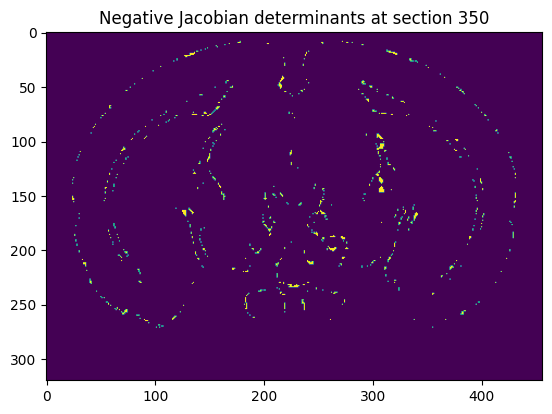

In [12]:
# Show the section with negative jacobian determinants
plt.imshow(jacobian_det[section]<0, cmap='viridis')
plt.title("Negative Jacobian determinants at section " + str(section))
plt.show()

Shape of curr_triangles: (10648, 2, 3, 2)


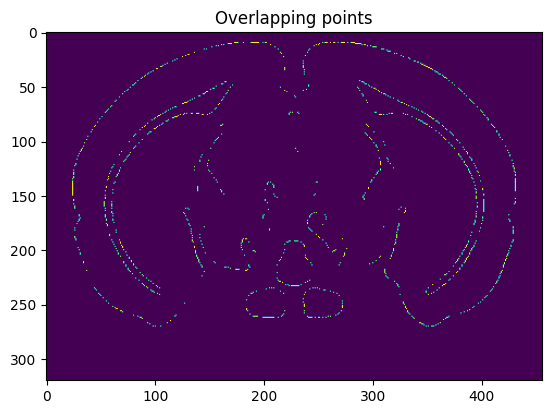

Number of overlapping triangle points: 59270


In [4]:
# In triangulate_points.ipynb, we saved the coordinates of points making up overlapping triangles
curr_triangles_path = "output/overlapping_triangles.npy"
# We also saved the coordinates of points making up collinear triangles, as well as the failed points 
# to their corresponding triangles when doing the circumcircle check below.

# Load delaunay triangulated points and errors (overlapping triangles)
curr_triangles = np.load(curr_triangles_path)
#unique_triangles = np.load(unique_triangles_path)

# Print the shapes of the arrays
print("Shape of curr_triangles:", curr_triangles.shape)
#print("Shape of unique_triangles:", unique_triangles.shape)

# Get the unique points that are part of the overlapping triangles
points = []
for overlap in curr_triangles:
    triangle1 = overlap[0]
    triangle2 = overlap[1]
    flattened_triangle1 = triangle1.flatten()
    flattened_triangle2 = triangle2.flatten()
    pairs_list1 = list(zip(flattened_triangle1[::2], flattened_triangle1[1::2]))
    pairs_list2 = list(zip(flattened_triangle2[::2], flattened_triangle2[1::2]))
    pt_set = set(pairs_list1 + pairs_list2)
    points += list(pt_set)

# Show the points with overlapping triangles
overlap_pts = np.zeros(jacobian_det[0].shape)
for pt in points:
    overlap_pts[pt] = 1
plt.imshow(overlap_pts, cmap='viridis')
plt.title("Overlapping points")
plt.show()

print("Number of overlapping triangle points:", len(points))

Compute percentage of negative Jacobians that are correspondences

In [5]:
def remove_duplicates(list1: np.ndarray, list2: np.ndarray):
    """
    Remove duplicate elements from list1 and the corresponding elements from list2.
    
    Parameters:
    - list1: The first list from which duplicates will be removed.
    - list2: The second list from which elements will be removed corresponding to the removed elements in list1.
    
    Returns:
    - list1_unique: The list1 with duplicates removed.
    - list2_filtered: The list2 with elements removed corresponding to the removed elements in list1.
    """
    seen = set()
    list1_unique = []
    list2_filtered = []
    
    for item1, item2 in zip(list1, list2):
        item1_tuple = tuple(item1)
        if item1_tuple not in seen:
            seen.add(item1_tuple)
            list1_unique.append(item1)
            list2_filtered.append(item2)
    
    return np.array(list1_unique), np.array(list2_filtered)


mpoints = np.load("1_3i/mpoints.npy")
fpoints = np.load("1_3i/fpoints.npy")

# Create a binary image to show the correspondences
curr_idx = 350
print("\nChecking slice", curr_idx)

# Get relevant corresponding image points
curr_mpoints = np.array([point[1:] for point in mpoints if point[0] == curr_idx])
curr_mpoints = curr_mpoints.astype(int)
curr_fpoints = np.array([point[1:] for point in fpoints if point[0] == curr_idx])
curr_fpoints = curr_fpoints.astype(int)
curr_mpoints_unique, curr_fpoints_unique = remove_duplicates(curr_mpoints, curr_fpoints)
print("\nNumber of unique moving points for slice", curr_idx, ":", len(curr_mpoints_unique))
print(curr_mpoints_unique)
print("\nNumber of unique fixed points for slice", curr_idx, ":", len(curr_fpoints_unique))
print(curr_fpoints_unique)
print()


# How many points in the negative jacobian determinant section are part of our failed Delaunay verification checks?
total_points = len(coordinates_list)
num_matches = 0
curr_points = curr_fpoints

# How many Jacobians are in the negative section that are part of the correspondences?
for i in range(total_points):
    jacobian_coord = coordinates_list[i]
    # Check if the point is in the correspondences
    #if jacobian_coord in curr_fpoints:
    #    num_matches += 1
    for j in range(len(curr_points)):
        if jacobian_coord == tuple(curr_points[j]):
            num_matches += 1
            #print(f"Point {jacobian_coord} found at index {j} in curr_fpoints_unique.")
            #print( "Corresponding point:", curr_fpoints[j])
            break
            

print("Number of points in negative Jacobian determinant section that are part of correspondences:")
print(f"\t{num_matches}/{total_points} ({num_matches/total_points*100:.2f}%)")


Checking slice 350

Number of unique moving points for slice 350 : 1326
[[ 17 178]
 [ 17 179]
 [ 18 172]
 ...
 [271 354]
 [271 355]
 [271 357]]

Number of unique fixed points for slice 350 : 1326
[[ 10 173]
 [ 10 174]
 [ 10 175]
 ...
 [270 354]
 [270 355]
 [270 356]]

Number of points in negative Jacobian determinant section that are part of correspondences:
	425/1287 (33.02%)


Compute percentage of negative Jacobians are part of overlapping triangles

In [6]:
# How many points in the negative jacobian determinant section are part of our failed Delaunay verification checks?
total_points = len(coordinates_list)
num_matches = 0
# Overlapping triangles
num_overlapping_triangles_matches = 0

# How many Jacobians are in the negative section that are part of the overlapping triangles?
for i in range(len(coordinates_list)):
    jacobian_coord = coordinates_list[i]
    has_matched = False
    for j in range(len(points)):
        # Check if the point is in the overlapping triangles check
        if jacobian_coord == points[j]:
            num_overlapping_triangles_matches += 1
            has_matched = True
            num_matches += 1
            #print(f"Found match: {jacobian_coord} with {points[j]}")
            break
    
# How many overlapping triangles are in the negative Jacobian determinant section?
# May double count since one point can be in multiple triangles
tri_count = 0
for i in range(len(points)):
    point = points[i]
    for j in range(len(coordinates_list)):
        if point == coordinates_list[j]:
            tri_count += 1
            #print(f"Found match: {point} with {coordinates_list[j]}")
            break
        
    
print("Number of points in negative Jacobian determinant section that are part of overlapping triangles:")
print(f"\t{num_overlapping_triangles_matches}/{total_points} ({num_overlapping_triangles_matches/total_points*100:.2f}%)")

print(tri_count, "/", len(points), "overlapping triangle points are in the negative Jacobian determinant section.")
print(tri_count/len(points)*100, "% of overlapping triangle points are in the negative Jacobian determinant section.")

Number of points in negative Jacobian determinant section that are part of overlapping triangles:
	171/1287 (13.29%)
9961 / 59270 overlapping triangle points are in the negative Jacobian determinant section.
16.80614138687363 % of overlapping triangle points are in the negative Jacobian determinant section.


Compute line intersections between correspondences

In [31]:
def orientation(p, q, r):
    """
    Calculate the orientation of the ordered triplet (p, q, r).
    
    Parameters:
    - p, q, r: Points represented as tuples or lists with two elements (x, y).
    
    Returns:
    - 0 if the points are collinear.
    - 1 if the points form a clockwise orientation.
    - 2 if the points form a counterclockwise orientation.
    """
    val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0
    return 1 if val > 0 else 2


def on_segment(p, q, r):
    """
    Check if point q lies on the line segment pr.
    
    Parameters:
    - p, q, r: Points represented as tuples or lists with two elements (x, y).
    
    Returns:
    - True if q lies on the line segment pr, False otherwise.
    """
    if min(p[0], r[0]) < q[0] < max(p[0], r[0]) and min(p[1], r[1]) < q[1] < max(p[1], r[1]):
        return True
    return False


def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - True if the line segments intersect, False otherwise.
    """
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
    
    # Special cases (collinear and one endpoint lies on the other line segment)
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True
    
    # Case: one endpoint is an endpoint on another line segment
    if np.array_equal(p1, p2) or np.array_equal(p1, q2) or np.array_equal(q1, p2) or np.array_equal(q1, q2):
        return False
    
    # General case
    if o1 != o2 and o3 != o4:
        return True

    return False

Did the line segments intersect? False


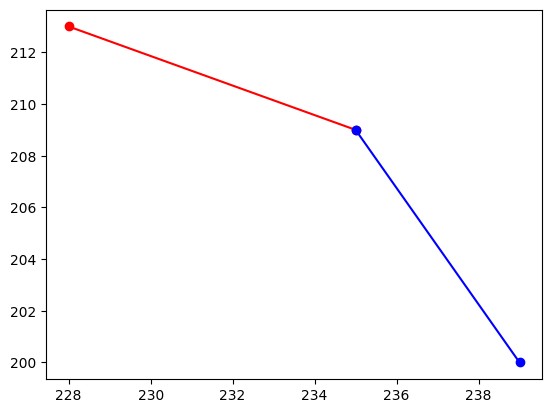

In [32]:
s1 = ([235, 209], [228, 213])
s2 = ([239, 200], [235, 209])

p1, q1 = s1
p2, q2 = s2

did_intersect = do_lines_intersect(p1, q1, p2, q2)
print("Did the line segments intersect?", did_intersect)

plt.plot([p1[0], q1[0]], [p1[1], q1[1]], 'ro-')
plt.plot([p2[0], q2[0]], [p2[1], q2[1]], 'bo-')
plt.show()

Swapped correspondences 0 and 2
Swapped correspondences 1 and 2
Swapped correspondences 50 and 51
Swapped correspondences 50 and 55
Swapped correspondences 60 and 61
Swapped correspondences 62 and 63
Swapped correspondences 82 and 88
Swapped correspondences 83 and 88
Swapped correspondences 86 and 89
Swapped correspondences 86 and 93
Swapped correspondences 90 and 96
Swapped correspondences 90 and 101
Swapped correspondences 120 and 134
Swapped correspondences 129 and 134
Swapped correspondences 155 and 156
Swapped correspondences 159 and 162
Swapped correspondences 161 and 172
Swapped correspondences 163 and 164
Swapped correspondences 169 and 177
Swapped correspondences 170 and 183
Swapped correspondences 195 and 203
Swapped correspondences 201 and 202
Swapped correspondences 206 and 211
Swapped correspondences 217 and 222
Swapped correspondences 232 and 236
Swapped correspondences 232 and 253
Swapped correspondences 234 and 240
Swapped correspondences 242 and 248
Swapped corresponde

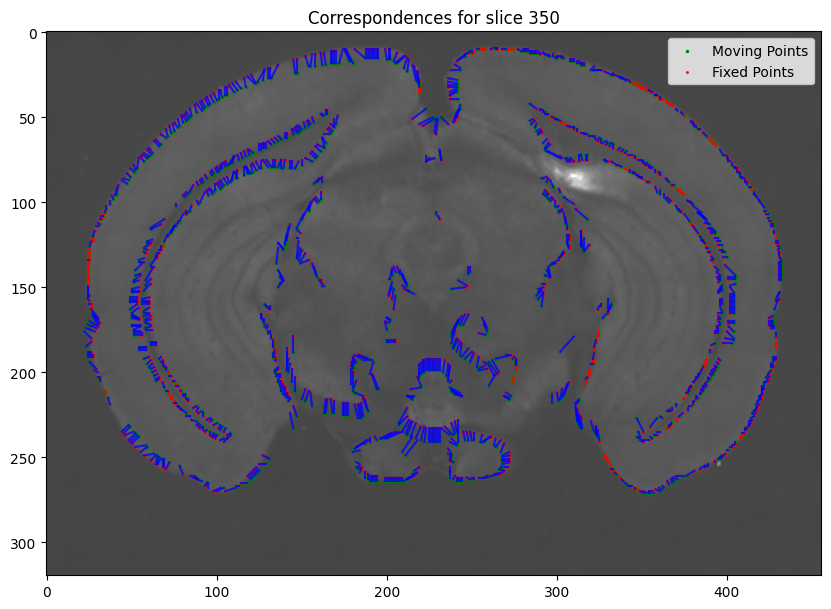

Number of intersecting segments: 7
Intersecting indices:
[(170, 183),
 (491, 503),
 (499, 508),
 (551, 556),
 (683, 688),
 (712, 715),
 (739, 751)]
Segment (array([ 43, 243]), array([ 52, 240])) intersects with segment (array([ 46, 242]), array([ 49, 241]))


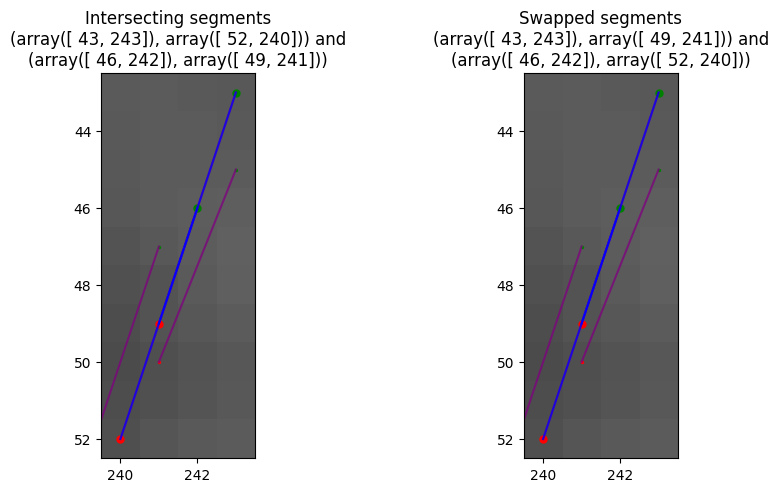

Segment (array([116,  74]), array([114,  75])) intersects with segment (array([118,  73]), array([114,  75]))


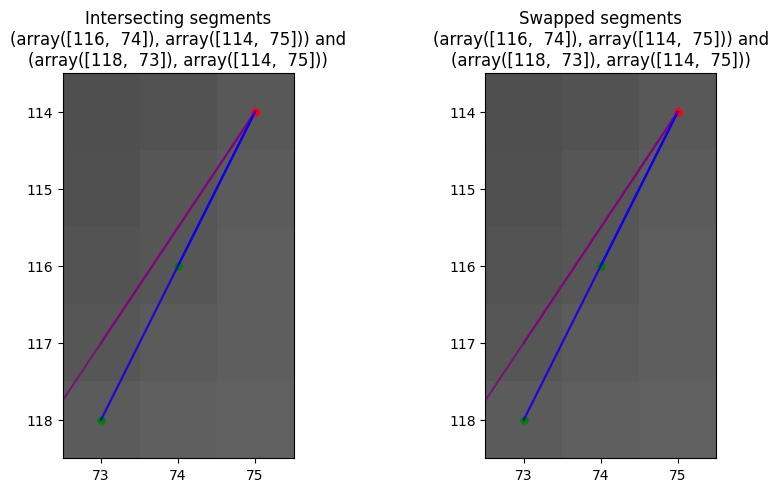

Segment (array([117,  73]), array([114,  75])) intersects with segment (array([120,  71]), array([114,  75]))


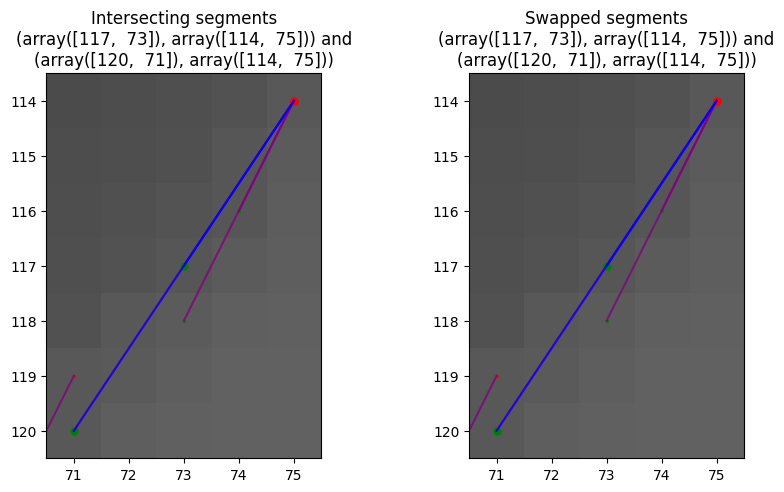

Segment (array([133, 301]), array([131, 303])) intersects with segment (array([132, 302]), array([131, 303]))


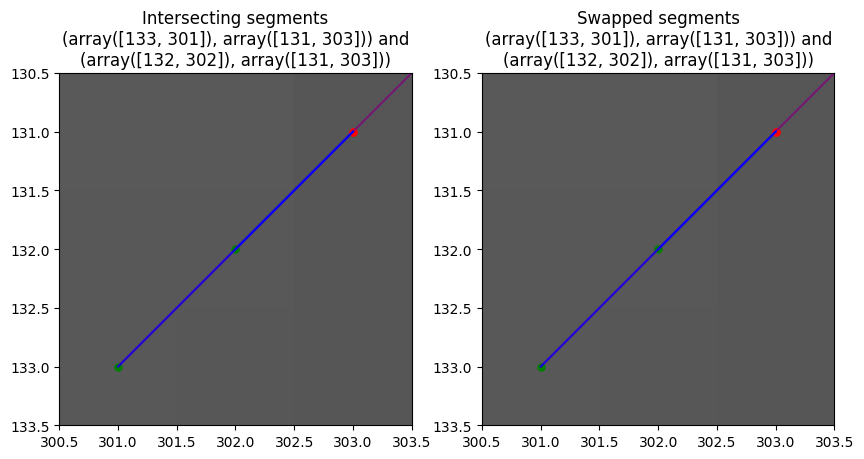

Segment (array([155, 430]), array([153, 431])) intersects with segment (array([157, 429]), array([153, 431]))


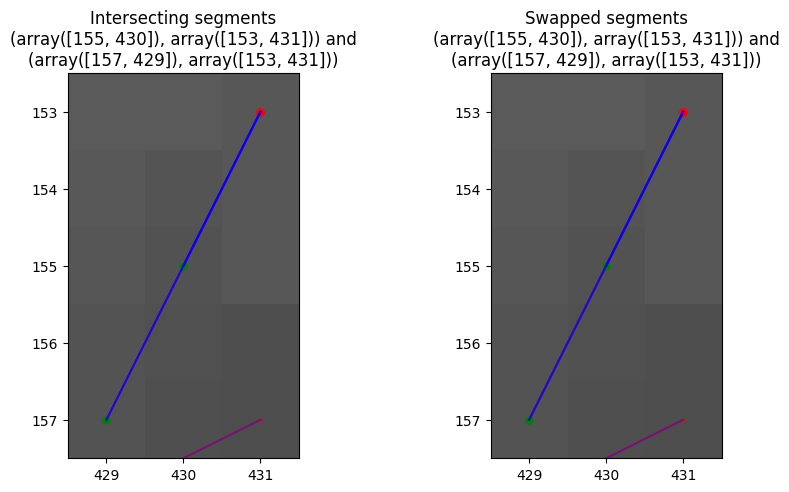

Segment (array([161, 129]), array([163, 131])) intersects with segment (array([160, 128]), array([162, 130]))


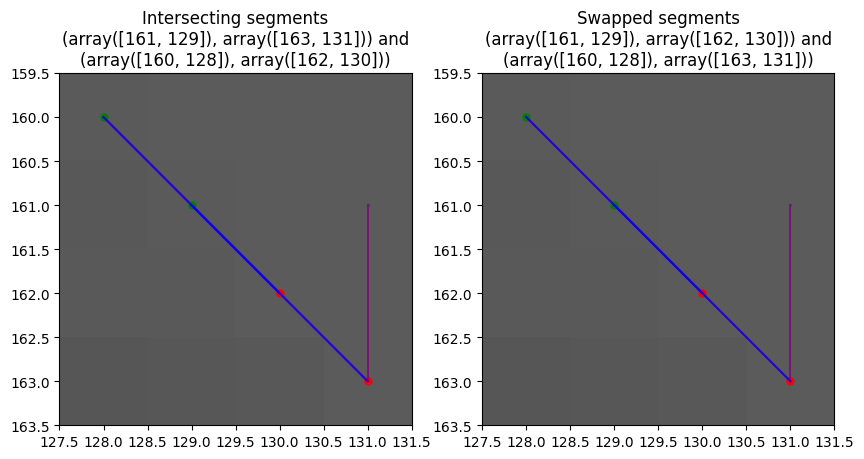

Segment (array([172, 258]), array([170, 257])) intersects with segment (array([174, 259]), array([168, 256]))


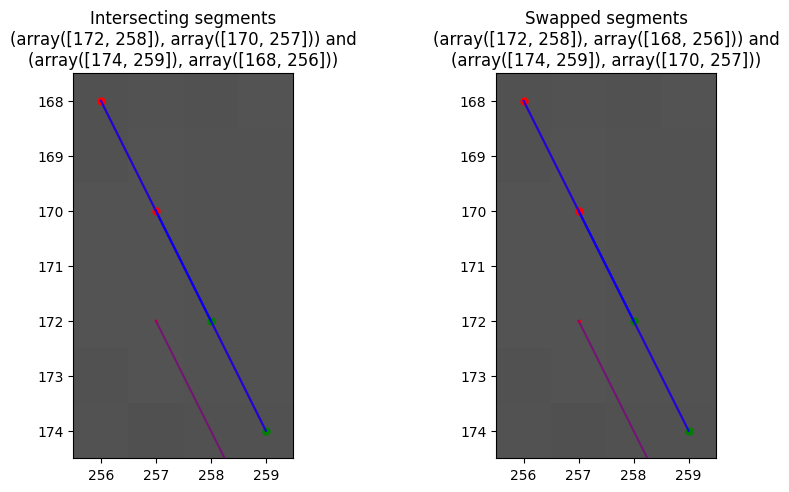

In [47]:
VISUALIZE_INTERSECTIONS = True

# Load the NIfTI file
nifti_img = nib.load('data/elastixRefined.nii.gz').get_fdata()[curr_idx]

mpts = curr_mpoints_unique[::1]
fpts = curr_fpoints_unique[::1]

def swap_correspondences(mpts: np.ndarray, fpts: np.ndarray) -> np.ndarray:
    """
    Swap the correspondences of the moving and fixed points if they intersect.
    
    Parameters:
    - mpts: The moving points.
    - fpts: The fixed points.
    
    Returns:
    - swapped_fpts: The swapped fixed points.
    """
    swapped_fpts = np.copy(fpts)
    for i in range(len(mpts)):
        line_segment1 = (mpts[i], fpts[i])
        for j in range(i + 1, len(mpts)):
            line_segment2 = (mpts[j], fpts[j])
            if do_lines_intersect(line_segment1[0], line_segment1[1], line_segment2[0], line_segment2[1]):
                swapped_fpts[i] = fpts[j]
                swapped_fpts[j] = fpts[i]
                print(f"Swapped correspondences {i} and {j}")
                #break  # Only checks for one intersection, TODO test more
    return swapped_fpts

fpts = swap_correspondences(mpts, fpts)
fpts = swap_correspondences(mpts, fpts)
fpts = swap_correspondences(mpts, fpts)


plt.figure(figsize=(10,10))
plt.imshow( nifti_img, cmap='gray', alpha=0.75)
plt.scatter( mpts[:,1], mpts[:,0], color='green', label='Moving Points', s=2)
plt.scatter( fpts[:,1], fpts[:,0], color='red', label='Fixed Points', s=1)
for i in range(len(mpts)):
    plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='blue', alpha=0.75)
plt.legend(loc='upper right')
plt.title( "Correspondences for slice " + str(curr_idx))
plt.show()

# Detect intersecting line segments
intersecting_segments = []
swapped_segments = []
intersecting_indices = []
for i in range(len(mpts)):
    line_segment1 = (mpts[i], fpts[i])
    for j in range(i + 1, len(mpts)):
        line_segment2 = (mpts[j], fpts[j])
        if do_lines_intersect(line_segment1[0], line_segment1[1], line_segment2[0], line_segment2[1]):
            intersecting_segments.append((line_segment1, line_segment2))
            swapped_segments.append(((mpts[i], fpts[j]), (mpts[j], fpts[i])))
            intersecting_indices.append((i, j))

# Print intersecting segments
print("Number of intersecting segments:", len(intersecting_segments))
print("Intersecting indices:")
pprint(intersecting_indices)
if VISUALIZE_INTERSECTIONS:
    for i in range(len(intersecting_segments)):
        seg1, seg2 = intersecting_segments[i]
        swapped_seg1, swapped_seg2 = swapped_segments[i]
        print(f"Segment {seg1} intersects with segment {seg2}")
        offset = 0.5

        # Show the intersecting segments on the plot
        plt.figure( figsize=(10,5))
        plt.subplot(1, 2, 1)
        plt.imshow( nifti_img, cmap='gray', alpha=0.75)
        
        # Show all points
        plt.scatter( mpts[:,1], mpts[:,0], color='green', s=2)
        plt.scatter( fpts[:,1], fpts[:,0], color='red', s=2)
        for i in range(len(mpts)):
            plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='purple', alpha=0.75)
        
        plt.scatter( seg2[0][1], seg2[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( seg2[1][1], seg2[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.scatter( seg1[0][1], seg1[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( seg1[1][1], seg1[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.plot([seg1[0][1], seg1[1][1]], [seg1[0][0], seg1[1][0]], color='blue', alpha=0.75)
        plt.plot([seg2[0][1], seg2[1][1]], [seg2[0][0], seg2[1][0]], color='blue', alpha=0.75)
        plt.title(f"Intersecting segments\n{seg1} and\n{seg2}")
        plt.xlim(min( seg1[0][1], seg1[1][1], seg2[0][1], seg2[1][1]) - offset, max( seg1[0][1], seg1[1][1], seg2[0][1], seg2[1][1]) + offset)
        plt.ylim(min( seg1[0][0], seg1[1][0], seg2[0][0], seg2[1][0]) - offset, max( seg1[0][0], seg1[1][0], seg2[0][0], seg2[1][0]) + offset)
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        
        
        # Second subplot
        plt.subplot(1, 2, 2)
        plt.imshow( nifti_img, cmap='gray', alpha=0.75)
        
        # Show all points
        plt.scatter( mpts[:,1], mpts[:,0], color='green', s=2)
        plt.scatter( fpts[:,1], fpts[:,0], color='red', s=2)
        for i in range(len(mpts)):
            plt.plot([mpts[i][1], fpts[i][1]], [mpts[i][0], fpts[i][0]], color='purple', alpha=0.75)
        
        plt.scatter( swapped_seg2[0][1], swapped_seg2[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( swapped_seg2[1][1], swapped_seg2[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.scatter( swapped_seg1[0][1], swapped_seg1[0][0], color='green', label='Moving Points', s=25)  # mpt
        plt.scatter( swapped_seg1[1][1], swapped_seg1[1][0], color='red', label='Fixed Points', s=25)  # fpt
        plt.plot([swapped_seg1[0][1], swapped_seg1[1][1]], [swapped_seg1[0][0], swapped_seg1[1][0]], color='blue', alpha=0.75)
        plt.plot([swapped_seg2[0][1], swapped_seg2[1][1]], [swapped_seg2[0][0], swapped_seg2[1][0]], color='blue', alpha=0.75)
        plt.title(f"Swapped segments\n{swapped_seg1} and\n{swapped_seg2}")
        plt.xlim(min( swapped_seg1[0][1], swapped_seg1[1][1], swapped_seg2[0][1], swapped_seg2[1][1]) - offset, max( swapped_seg1[0][1], swapped_seg1[1][1], swapped_seg2[0][1], swapped_seg2[1][1]) + offset)
        plt.ylim(min( swapped_seg1[0][0], swapped_seg1[1][0], swapped_seg2[0][0], swapped_seg2[1][0]) - offset, max( swapped_seg1[0][0], swapped_seg1[1][0], swapped_seg2[0][0], swapped_seg2[1][0]) + offset)
        plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
        plt.show()
        
    # Negative Jacobian implies intersection ( preferred) or
    # if we remove all intersections, we remove all negative Jacobians
    # intersection implies negative Jacobian? Need to show either way
    #  it is possible that even after removign all intersections, there is still negative Jacobian

In [ ]:
def swap_segments(intersecting_segments):
    """
    Swap the endpoints of the intersecting segments.
    
    Parameters:
    - intersecting_segments: A list of tuples, where each tuple contains two line segments.
    
    Returns:
    - swapped_segments: A list of tuples, where each tuple contains two line segments with swapped endpoints.
    """
    swapped_segments = []
    for seg1, seg2 in intersecting_segments:
        swapped_segments.append(((seg1[0], seg2[1]), (seg2[0], seg1[1])))
    return swapped_segments

In [9]:
# How many of our negative Jacobian determinant points are part of the intersecting segments?
num_intersecting_matches = 0
for coord in coordinates_list:
    for seg1, seg2 in intersecting_segments:
        if coord == tuple(seg1[0]) or coord == tuple(seg1[1]) or coord == tuple(seg2[0]) or coord == tuple(seg2[1]):
            num_intersecting_matches += 1
            break

# How many points in the negative jacobian determinant section are part of our failed Delaunay verification checks?
total_points = len(coordinates_list)

print("Number of points in negative Jacobian determinant section that are part of intersecting segments:")
print(f"\t{num_intersecting_matches}/{total_points} ({num_intersecting_matches/total_points*100:.2f}%)")

Number of points in negative Jacobian determinant section that are part of intersecting segments:
	68/1287 (5.28%)
